In [22]:
using DifferentialEquations, PyPlot, Distributions, LaTeXStrings

In [2]:
# PURPOSE: simulate from the univariate plankton model
# Illustrate: 
# - discretization and numerical solution (and built-in ODE solvers) 
# - adding stichasticity (additive white noise, stochastic parameters)
# - realization and ensembles for time series models 

#############
# SET UP 

T = 365*4 # set duration of simulaton in days
dt = 1 # set time step (here 1 day)
nt = T*dt # determine model steps needed

γ = 0.25  # growth parameter
λ = 0.1  # mortality/loss parameter
om = 2*π/365; # annual frequency 

In [3]:
P = zeros(nt);
P[1] = 2.5
for i in 2:nt
    time = i*dt
    P[i]=P[i-1]+dt*(γ*(1+sin(om*time))*P[i-1] - λ*P[i-1]^2)
end

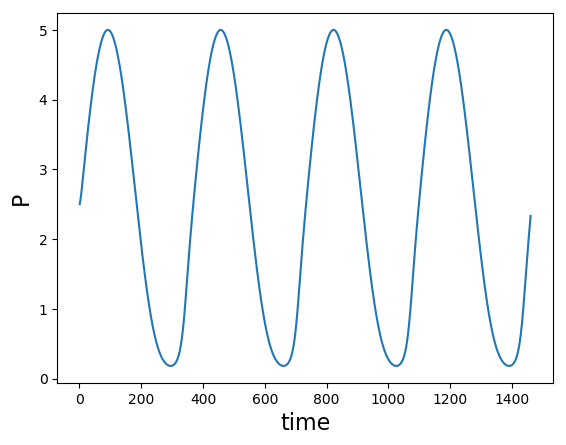

In [4]:
fig, ax = PyPlot.subplots()
ax.plot(collect(1:dt:nt),P)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16);

In [5]:
Growth(u,p,t) = p[1]*(1+sin(p[2]*t))*u - p[3]*u^2
u₀ = 2.5;
tspan = (0.0,nt)
p = [γ, om, λ]
prob = ODEProblem(Growth,u₀,tspan,p)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1460.0)
u0: 2.5

In [6]:
sol = solve(prob,reltol=1e-6,saveat=1.0);

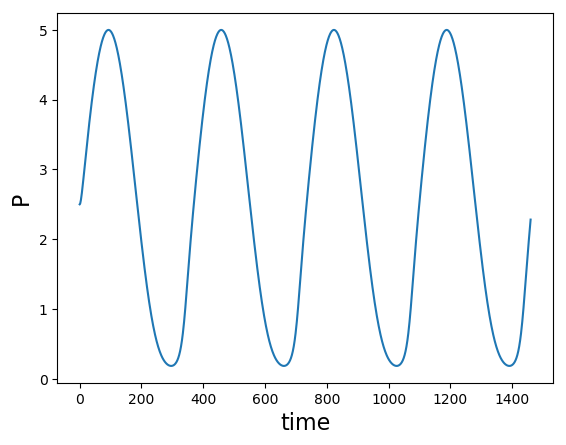

In [7]:
fig, ax = PyPlot.subplots()
ax.plot(sol.u)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16);

In [10]:
###############
# STOCHASTICITY - SINGLE REALIZATIONS

# (1) adding stochasticit using additive, signal-scaled white noise

# accumulator for state vector
P = zeros(nt);
P[1] = 2.5
for i in 2:nt
    time = i*dt
    noise = sqrt(dt)*0.05*P[i-1]*rand(Normal())
    P[i]=P[i-1]+dt*(γ*(1+sin(om*time))*P[i-1] - λ*P[i-1]^2) + noise
end

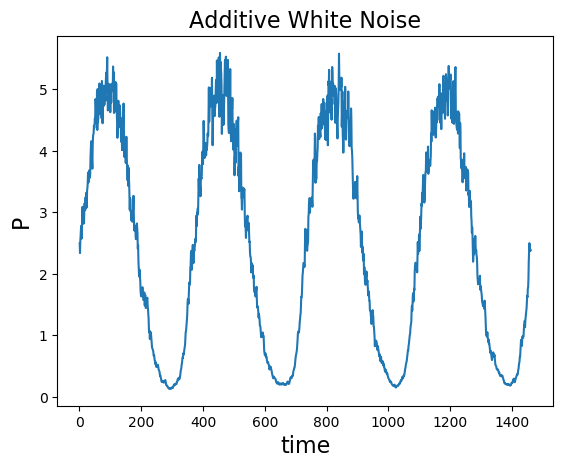

In [13]:
fig, ax = PyPlot.subplots()
ax.plot(collect(1:dt:nt),P)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16)
ax.set_title("Additive White Noise",fontsize=16);

In [17]:
P = zeros(nt);
P[1] = 2.5
for i in 2:nt
    time = i*dt
    γs = rand(LogNormal(log(0.25),0.05))
    λs = rand(Uniform(0.08,0.12))
    P[i]=P[i-1]+dt*(γs*(1+sin(om*time))*P[i-1] - λs*P[i-1]^2)
end

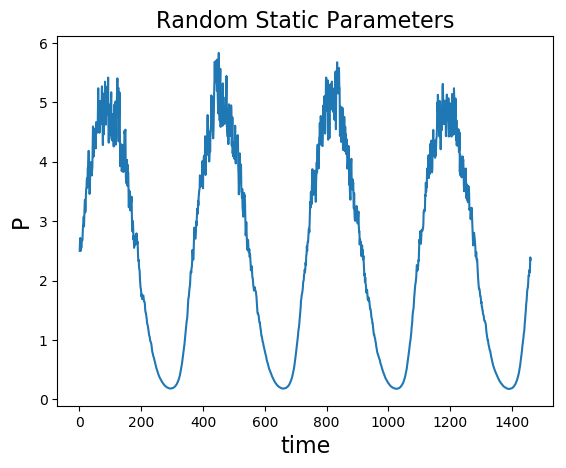

In [19]:
fig, ax = PyPlot.subplots()
ax.plot(collect(1:dt:nt),P)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16)
ax.set_title("Random Static Parameters",fontsize=16);

In [21]:
# Approach 2: parameters are dynamic, follow stochastic process AR(1)

# create dynamical parameters 
nday = 365
dγ = zeros(nday)
dγ[1] = 0
dλ = zeros(nday)
dλ[1] = 0

for i in 2:nday
    dγ[i] = 0.9*dγ[i-1]+0.01*rand(Normal())
    dλ[i] = 0.95*dλ[i-1]+0.01*rand(Normal())
end

γt = γ .+ dγ
λt = λ .+ dλ;

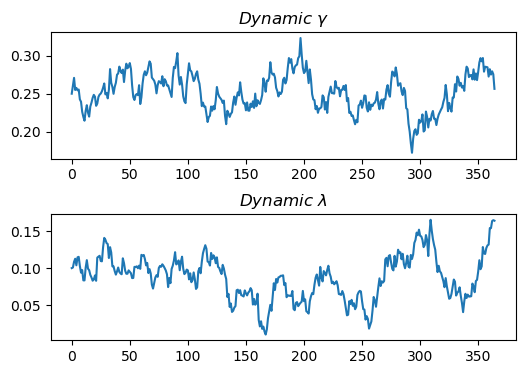

In [23]:
fig, axs = PyPlot.subplots(2, 1, figsize = (6,4))
axs[1].plot(γt)
axs[2].plot(λt)
axs[1].set_title(L"Dynamic\;\gamma")
axs[2].set_title(L"Dynamic\;\lambda")
fig.subplots_adjust(wspace=0.3, hspace=0.44)

In [47]:
# use these time-varying parameters in simulation
P = zeros(nt);
P[1] = 2.5
dγ = 0
dλ = 0
for i in 2:nt
    time = i*dt
    dγ = 0.9*dγ+0.01*rand(Normal())
    dλ = 0.95*dλ+0.005*rand(Normal())
    P[i]=P[i-1]+dt*((γ + dγ)*(1+sin(om*time))*P[i-1] - (λ + dλ)*P[i-1]^2)
end

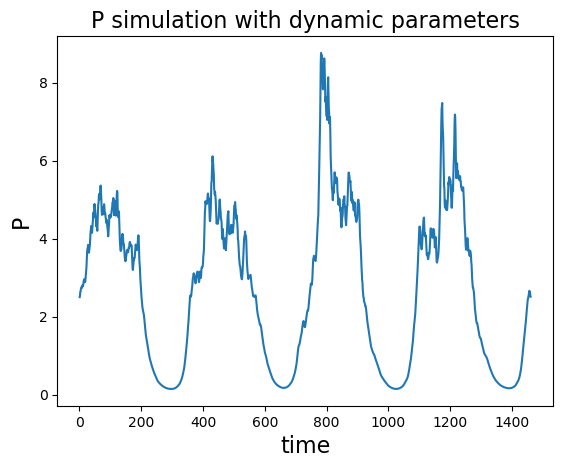

In [48]:
fig, ax = PyPlot.subplots()
ax.plot(collect(1:dt:nt),P)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16)
ax.set_title("P simulation with dynamic parameters",fontsize=16);

In [36]:
##### ENSEMBLES ########

###########
# Approach 1: parameters follow pdf, one parameter set per realization
nr = 50;
Pacc = zeros(nt,nr);
P = zeros(nt);
P[1] = 2.5
for j in 1:nr
    γs = rand(LogNormal(log(0.25),0.05))
    λs = rand(Uniform(0.08,0.12))
    for i in 2:nt
        time = i*dt
        P[i]=P[i-1]+dt*(γs*(1+sin(om*time))*P[i-1] - λs*P[i-1]^2)
    end
    Pacc[:,j] = P
end

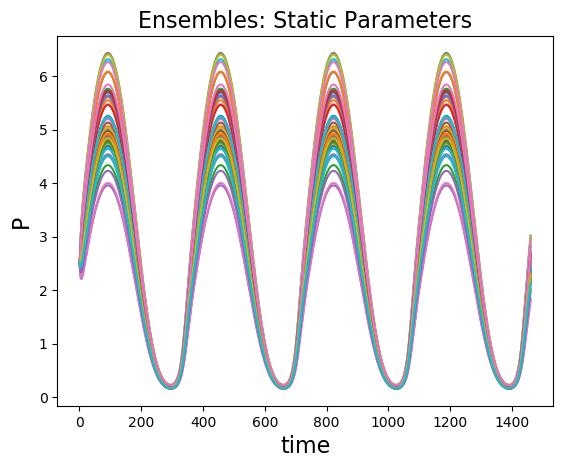

In [38]:
fig, ax = PyPlot.subplots()
for i in 1:nr
    ax.plot(collect(1:dt:nt),Pacc[:,i])
end
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16)
ax.set_title("Ensembles: Static Parameters",fontsize=16);

In [49]:
###########
# Approach 2: parameters are dynamic (AR)
# create ensembles
nr = 100;
Pacc = zeros(nt,nr);
P = zeros(nt);
P[1] = 2.5
dγ = 0
dλ = 0
for j in 1:nr
    for i in 2:nt
        time = i*dt
        dγ = 0.9*dγ+0.01*rand(Normal())
        dλ = 0.95*dλ+0.005*rand(Normal())
        P[i]=P[i-1]+dt*((γ + dγ)*(1+sin(om*time))*P[i-1] - (λ + dλ)*P[i-1]^2)
    end
    Pacc[:,j] = P
end

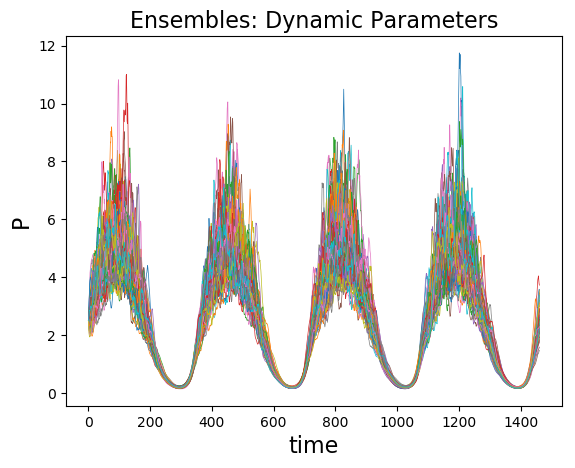

In [51]:
fig, ax = PyPlot.subplots()
for i in 1:nr
    ax.plot(collect(1:dt:nt),Pacc[:,i],lw=0.5)
end
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16)
ax.set_title("Ensembles: Dynamic Parameters",fontsize=16);

In [52]:
using Statistics

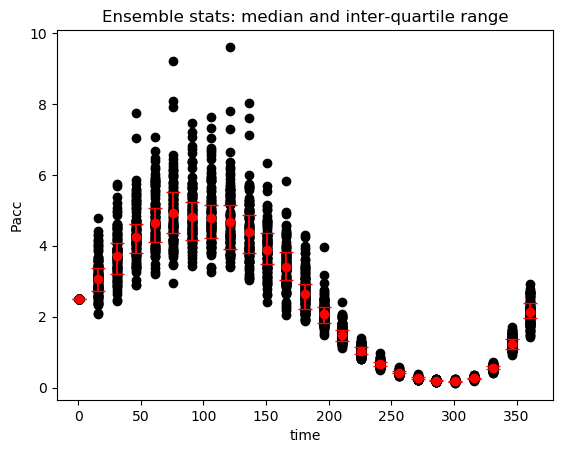

In [65]:
Pmed = median(Pacc,dims=2);
Pupper = zeros(nt)
Plower = zeros(nt)
for i in 1:nt
    Pupper[i] = quantile(Pacc[i,:],0.75)
    Plower[i] = quantile(Pacc[i,:],0.25)
end
idx = collect(1:15:365);
fig, ax = plt.subplots()
ax.plot(idx, Pacc[idx,:], marker="o", linestyle="none", color="black")
ax.errorbar(x=idx, y=Pmed[idx], yerr=[Pupper[idx]-Pmed[idx],Pmed[idx]-Plower[idx]], 
            color="red", zorder=5, linestyle="none", marker="o", capsize=5)
ax.set(title="Ensemble stats: median and inter-quartile range", xlabel="time", ylabel="Pacc");